# Amazon Fine Food Review Analysis

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Reading the data 

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


In [2]:
#using aqlite table to read data
con=sqlite3.connect(r"C:\Users\DELL\Desktop\database.sqlite")
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 


In [3]:
#Give reviews >3 as positive rating(1)  and <3 as negative(0)
def partition(x):
    if x<3:
        return 0
    return 1

actual_score=filtered_data["Score"]
positive_negative=actual_score.map(partition)
filtered_data["Score"]=positive_negative

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
np.sum(display["COUNT(*)"].value_counts().values>1)

101

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

# Exploratory Data Analysis

# [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.



In [9]:
#sorting the data in ascending order acdcording to product id
sorted_data =filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False, kind="quicksort",na_position="last")

In [10]:
#deduplication of data
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions



In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# Preprocessing

# [3.1].  Preprocessing Review Text
​
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
​
Hence in the Preprocessing phase we do the following in the order below:-
​
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>
​
After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_0=re.sub(r"http\S+","",sent_0)
sent_1000=re.sub(r"http\S+","",sent_1000)
sent_1500=re.sub(r"htttp\S+","",sent_1500)
sent_4900=re.sub(r"http\S+","",sent_4900)
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
soup=BeautifulSoup(sent_0,"lxml")
text=soup.get_text
print(text)
print("="*50)
soup=BeautifulSoup(sent_1000,"lxml")
text=soup.get_text
print(text)
print("="*50)
soup=BeautifulSoup(sent_1500,"lxml")
text=soup.get_text
print(text)
("="*50)
soup=BeautifulSoup(sent_4900,"lxml")
text=soup.get_text
print(text)

<bound method Tag.get_text of <html><body><p>My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.</p></body></html>>
<bound method Tag.get_text of <html><body><p>The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.</p></body></html>>
<bound method Tag.get_text of <html><body><p>was way to hot for my blood, took a bite and did a jig  lol</p></body></html>>
<bound method Tag.get_text of <html><body><p>My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of

In [17]:
def deconcracted(phrase):
     # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundent
preprocessed_reviews = []
for sentance in final_data['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = deconcracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [20]:
final_data["CleanedText"]=preprocessed_reviews

# Linear Kernel/ Linear SVM

# 4.Featurization

# 4.1 Bag of words

In [21]:
X=final_data["CleanedText"].values
y=final_data["Score"]

In [22]:
# from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [23]:
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
count_vect=CountVectorizer().fit(X_tr)

In [26]:
X_tr=count_vect.transform(X_tr)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)


In [27]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Hyperparameter_SGD_bow

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score


In [29]:
alpha = [10 ** x for x in range(-4, 4)] # hyperparam for SGD classifier. 
from sklearn.metrics import roc_auc_score

For values of alpha =  0.0001 The train roc_auc_score is: 0.9957769086996912 And CV roc_auc_score is: 0.8589385248706825
For values of alpha =  0.001 The train roc_auc_score is: 0.9960777714955495 And CV roc_auc_score is: 0.8579693982780536
For values of alpha =  0.01 The train roc_auc_score is: 0.9966093758999321 And CV roc_auc_score is: 0.8656133517281172
For values of alpha =  0.1 The train roc_auc_score is: 0.9948047743275743 And CV roc_auc_score is: 0.889179152029877
For values of alpha =  1 The train roc_auc_score is: 0.976212097770654 And CV roc_auc_score is: 0.8769876187070118
For values of alpha =  10 The train roc_auc_score is: 0.7555769252869529 And CV roc_auc_score is: 0.6608337451503189
For values of alpha =  100 The train roc_auc_score is: 0.5746390482477206 And CV roc_auc_score is: 0.5387711031040936
For values of alpha =  1000 The train roc_auc_score is: 0.5671946784998602 And CV roc_auc_score is: 0.5333347906665553


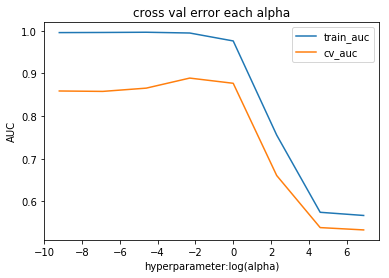

In [30]:
from sklearn.calibration import CalibratedClassifierCV

train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [31]:
clf_bow_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]

In [32]:
clf_bow_sgd_l2_alpha

0.1

In [33]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [34]:
model_bow_sgd_l2=SGDClassifier(loss="hinge",alpha=0.1,penalty="l2")
model_bow_sgd_l2.fit(X_tr,y_tr)

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

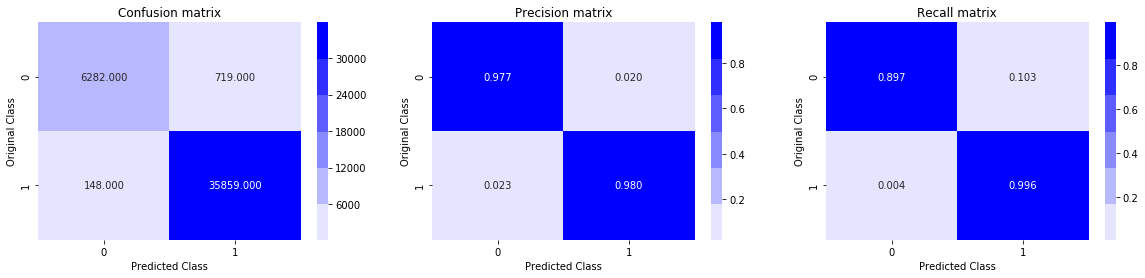

97.98409598214286


In [35]:
#comfusion matrix on train data
y_pred_tr = model_bow_sgd_l2.predict(X_tr)
acc_tr_bow_sgd_l2=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_bow_sgd_l2)

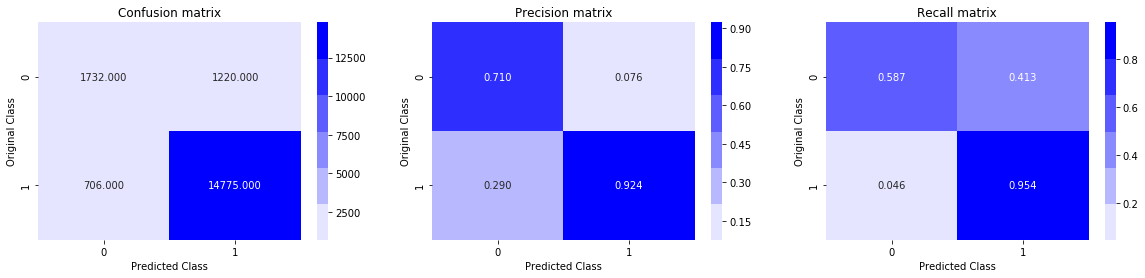

89.55134812564422


In [36]:
#confusion matrix on CV data
y_pred_cv = model_bow_sgd_l2.predict(X_cv)
acc_cv_bow_sgd_l2=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_bow_sgd_l2)

# l1 regularizer

# hyperparameter tuning: finding best alpha

For values of alpha =  0.0001 The train roc_auc_score is: 0.9782018928241932 And CV roc_auc_score is: 0.8644349249512778
For values of alpha =  0.001 The train roc_auc_score is: 0.9412712375234595 And CV roc_auc_score is: 0.8436096332089218
For values of alpha =  0.01 The train roc_auc_score is: 0.7708400761811274 And CV roc_auc_score is: 0.7382339817197021
For values of alpha =  0.1 The train roc_auc_score is: 0.5582112921931927 And CV roc_auc_score is: 0.5572850993673686
For values of alpha =  1 The train roc_auc_score is: 0.49835373588878296 And CV roc_auc_score is: 0.4936047907488311
For values of alpha =  10 The train roc_auc_score is: 0.5020869567224995 And CV roc_auc_score is: 0.5024055516780863
For values of alpha =  100 The train roc_auc_score is: 0.4999563579757046 And CV roc_auc_score is: 0.5000322976551902
For values of alpha =  1000 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5


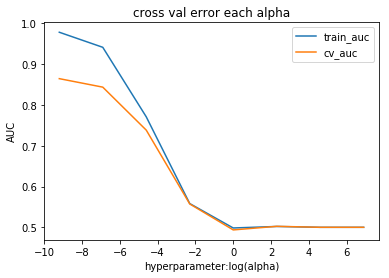

In [37]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l1",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [38]:
clf_bow_sgd_l1_alpha=alpha[cv_auc.index(max(cv_auc))]

In [39]:
print(clf_bow_sgd_l1_alpha)

0.0001


In [40]:
model_bow_sgd_l2=SGDClassifier(loss="hinge",alpha=0.0001,penalty="l1")
model_bow_sgd_l2.fit(X_tr,y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

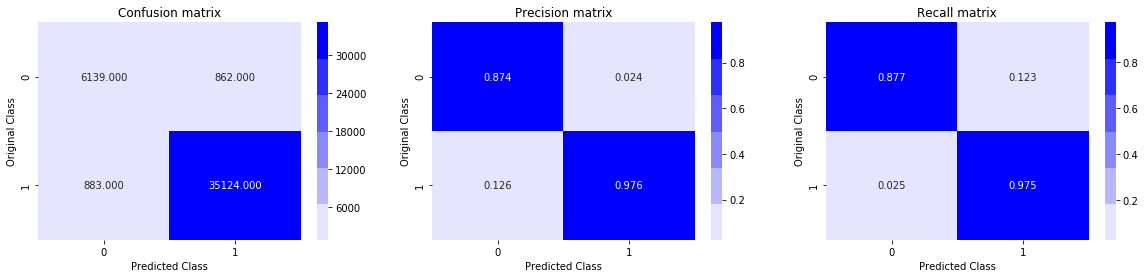

95.94261532738095


In [41]:
#comfusion matrix on train data
y_pred_tr = model_bow_sgd_l2.predict(X_tr)
acc_tr_bow_sgd_l2=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_bow_sgd_l2)

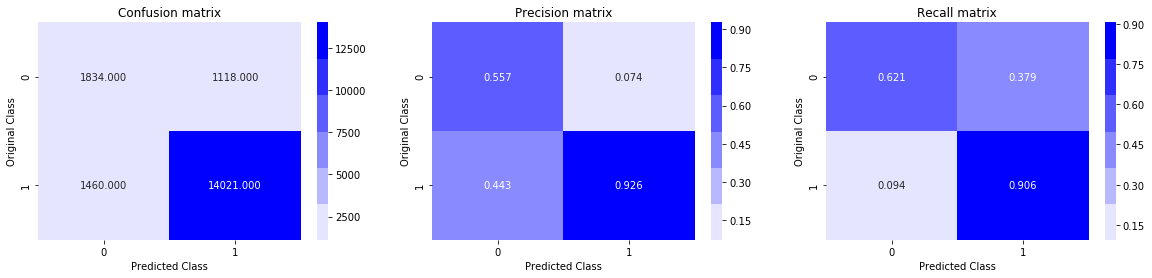

86.01421363858299


In [42]:
#confusion matrix on CV data
y_pred_cv = model_bow_sgd_l2.predict(X_cv)
acc_cv_bow_sgd_l2=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_bow_sgd_l2)

# Top ten features

In [43]:
model_bow_sgd_l2.classes_

array([0, 1], dtype=int64)

In [44]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_feature_names = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_feature_names[:n], coefs_feature_names[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_0, fn_0), (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_0, fn_0, coef_1, fn_1))


In [45]:
show_most_informative_features(count_vect,model_bow_sgd_l2)

		Negative				Positive
________________________________________________________________________________________________
	-2038.0092	assimilate     		2068.5344	compotes       
	-1994.6894	donot          		2066.5684	hd             
	-1971.6527	lizard         		2012.0077	virtual        
	-1971.6527	monochromatic  		1996.6415	irks           
	-1971.6527	shading        		1996.6415	bidding        
	-1954.8732	mulched        		1990.7979	rangoon        
	-1871.5014	sheetz         		1863.1758	siren          
	-1759.7747	jitter         		1863.1758	rituals        
	-1744.8597	ficus          		1857.9825	absorbency     
	-1744.8597	miraclegro     		1851.2754	satiation      


# 4.2Tfidf

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
X=final_data["CleanedText"].values
y=final_data["Score"]
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_vect=tfidf_vect.fit(X_tr)
X_tr=tfidf_vect.transform(X_tr)
X_cv=tfidf_vect.transform(X_cv)
X_test=tfidf_vect.transform(X_test)
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# hyperparamter tuning:finding best alpha

For values of alpha =  0.0001 The train roc_auc_score is: 0.9995795509135785 And CV roc_auc_score is: 0.9326768704561995
For values of alpha =  0.001 The train roc_auc_score is: 0.9996028897283412 And CV roc_auc_score is: 0.932301937791842
For values of alpha =  0.01 The train roc_auc_score is: 0.9997137739862966 And CV roc_auc_score is: 0.9338051165546357
For values of alpha =  0.1 The train roc_auc_score is: 0.9998775000923837 And CV roc_auc_score is: 0.938120409574196
For values of alpha =  1 The train roc_auc_score is: 0.991988391358753 And CV roc_auc_score is: 0.9456523078017396
For values of alpha =  10 The train roc_auc_score is: 0.8911120489289232 And CV roc_auc_score is: 0.8400927692146214
For values of alpha =  100 The train roc_auc_score is: 0.7004082440928627 And CV roc_auc_score is: 0.6675862481751065
For values of alpha =  1000 The train roc_auc_score is: 0.7004087657418533 And CV roc_auc_score is: 0.6675859662545421


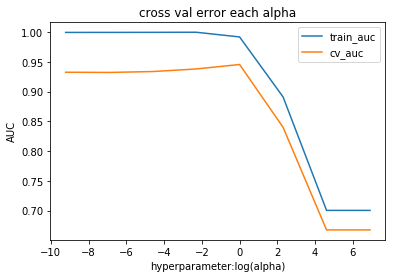

In [47]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [48]:
clf_tfidf_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_tfidf_sgd_l2_alpha)

1


In [49]:
model_tfidf_sgd_l2=SGDClassifier(loss="hinge",alpha=1,penalty="l2")
model_tfidf_sgd_l2.fit(X_tr,y_tr)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

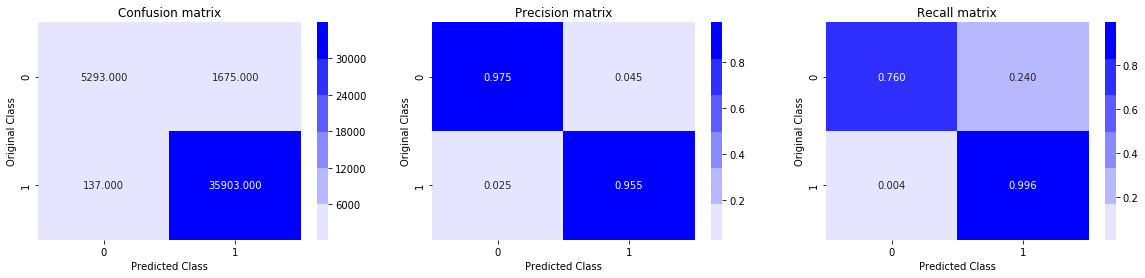

95.78683035714286


In [50]:
#comfusion matrix on train data
y_pred_tr = model_tfidf_sgd_l2.predict(X_tr)
acc_tr_tfidf_sgd_l2=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_tfidf_sgd_l2)

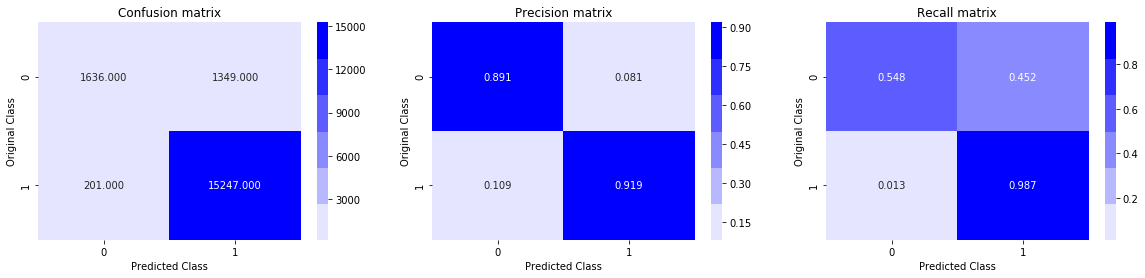

91.59116801388814


In [51]:
#comfusion matrix on train data
y_pred_cv = model_tfidf_sgd_l2.predict(X_cv)
acc_cv_tfidf_sgd_l2=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_tfidf_sgd_l2)

# l1 regularizer

For values of alpha =  0.0001 The train roc_auc_score is: 0.9883087271637203 And CV roc_auc_score is: 0.9211345654563167
For values of alpha =  0.001 The train roc_auc_score is: 0.9473594566121837 And CV roc_auc_score is: 0.8925076790824484
For values of alpha =  0.01 The train roc_auc_score is: 0.7760830747122409 And CV roc_auc_score is: 0.7534299540165874
For values of alpha =  0.1 The train roc_auc_score is: 0.5817486924529576 And CV roc_auc_score is: 0.5779354002881661
For values of alpha =  1 The train roc_auc_score is: 0.5078473708413027 And CV roc_auc_score is: 0.5084678961873064
For values of alpha =  10 The train roc_auc_score is: 0.5054524823164974 And CV roc_auc_score is: 0.5038020566322029
For values of alpha =  100 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  1000 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5


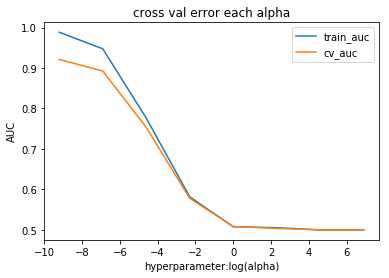

In [52]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l1",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [53]:
clf_tfidf_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_tfidf_sgd_l2_alpha)

0.0001


In [54]:
model_tfidf_sgd_l1=SGDClassifier(loss="hinge",alpha=0.0001,penalty="l1")
model_tfidf_sgd_l1.fit(X_tr,y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

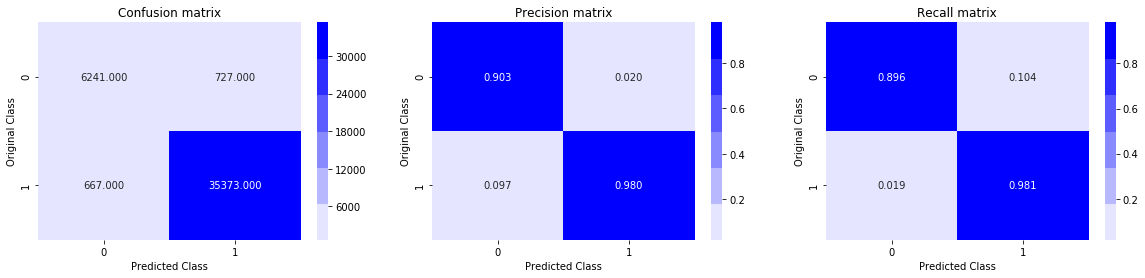

96.75874255952381


In [55]:
#comfusion matrix on train data
y_pred_tr = model_tfidf_sgd_l1.predict(X_tr)
acc_tr_tfidf_sgd_l1=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_tfidf_sgd_l1)

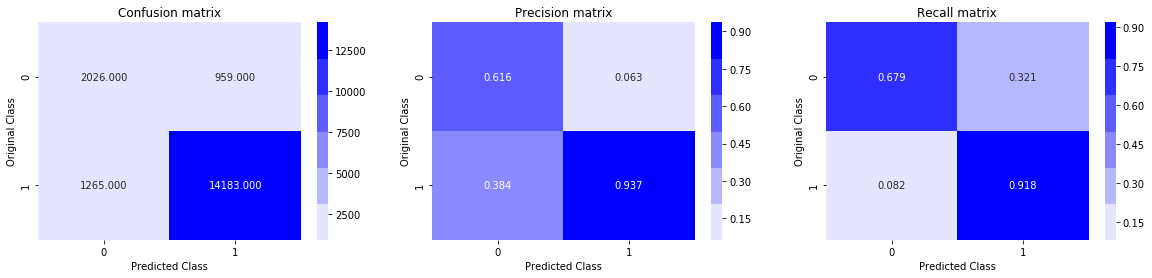

87.93468236315304


In [56]:
#comfusion matrix on train data
y_pred_cv = model_tfidf_sgd_l1.predict(X_cv)
acc_cv_tfidf_sgd_l1=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_tfidf_sgd_l1)

# top ten features

In [57]:
show_most_informative_features(tfidf_vect,model_tfidf_sgd_l2)

		Negative				Positive
________________________________________________________________________________________________
	-0.0293	worst          		0.0482	great          
	-0.0284	not worth      		0.0385	good           
	-0.0264	disappointed   		0.0374	love           
	-0.0252	not buy        		0.0351	best           
	-0.0241	not recommend  		0.0296	delicious      
	-0.0237	horrible       		0.0265	loves          
	-0.0233	terrible       		0.0234	perfect        
	-0.0232	disappointing  		0.0233	nice           
	-0.0225	not good       		0.0224	excellent      
	-0.0221	disappointment 		0.0214	favorite       


# 4.3 avg word2vec

In [58]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

C:\Users\DELL\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [59]:
X=final_data["CleanedText"].values
y=final_data["Score"]

In [60]:
final_data["Score"].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [61]:
# split the data set into train and test

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)


In [62]:
# training our own word to vec
list_of_sent_tr=[]
for sent in X_tr:
    list_of_sent_tr.append(sent.split())
    
list_of_sent_cv=[]
for sent in X_cv:
    list_of_sent_cv.append(sent.split())
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [63]:
w2v_model=Word2Vec(list_of_sent_tr,min_count=5,size=50, workers=4)

In [64]:
w2v_words = list(w2v_model.wv.vocab)

In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

43008
50


In [66]:
X_tr=sent_vectors_tr

In [67]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

18433
50


In [68]:
X_cv=sent_vectors_cv

In [69]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

26332
50


In [70]:
X_test=sent_vectors_test

In [71]:
from sklearn.preprocessing import Normalizer
scaler=Normalizer().fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

For values of alpha =  0.0001 The train roc_auc_score is: 0.6258572112984835 And CV roc_auc_score is: 0.6147020277798572
For values of alpha =  0.001 The train roc_auc_score is: 0.5995759816097196 And CV roc_auc_score is: 0.5865803848561482
For values of alpha =  0.01 The train roc_auc_score is: 0.5913592602675177 And CV roc_auc_score is: 0.5786714250222675
For values of alpha =  0.1 The train roc_auc_score is: 0.5908106483806388 And CV roc_auc_score is: 0.5784119611997652
For values of alpha =  1 The train roc_auc_score is: 0.5904015910831568 And CV roc_auc_score is: 0.577501494444788
For values of alpha =  10 The train roc_auc_score is: 0.5908621244130717 And CV roc_auc_score is: 0.5784859511340965
For values of alpha =  100 The train roc_auc_score is: 0.5911626799481465 And CV roc_auc_score is: 0.5786513327409799
For values of alpha =  1000 The train roc_auc_score is: 0.5908621244130717 And CV roc_auc_score is: 0.5784859294361685


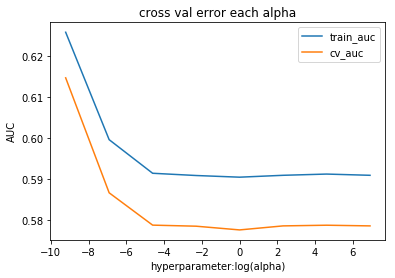

In [72]:

train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i,class_weight="balanced")
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [73]:
clf_avgw2vec_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_avgw2vec_sgd_l2_alpha)

0.0001


In [74]:
model_avgw2vec_sgd_l2=SGDClassifier(loss="hinge",alpha=clf_avgw2vec_sgd_l2_alpha,penalty="l2",class_weight="balanced")
model_avgw2vec_sgd_l2.fit(X_tr,y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

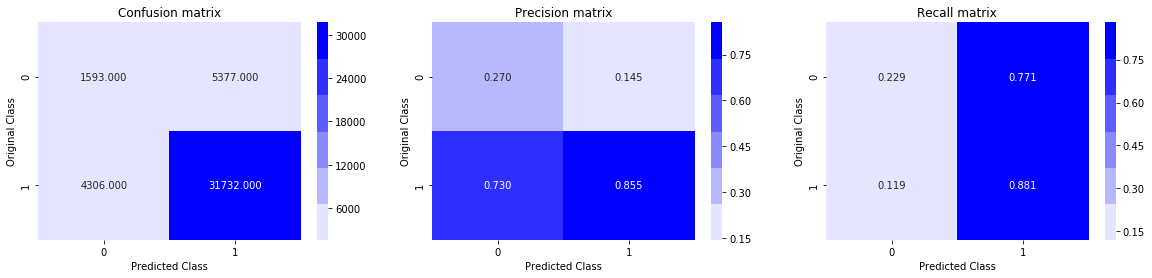

77.48558407738095


In [75]:
#comfusion matrix on train data
y_pred_tr = model_avgw2vec_sgd_l2.predict(X_tr)
acc_tr_avgw2vec_sgd_l2=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_avgw2vec_sgd_l2)

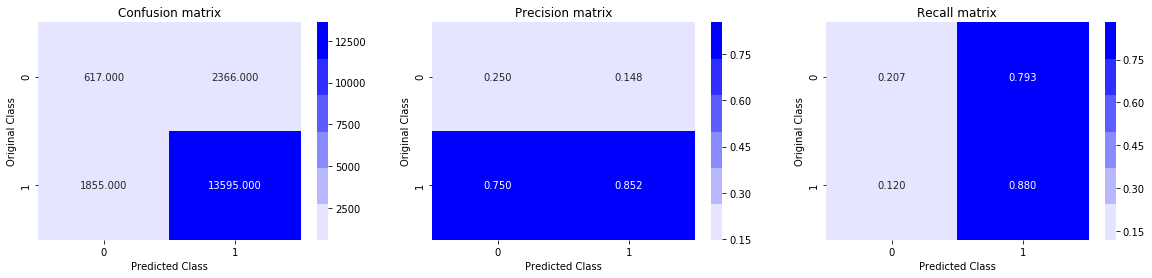

77.1008517333044


In [76]:
#comfusion matrix on train data
y_pred_cv = model_avgw2vec_sgd_l2.predict(X_cv)
acc_cv_avgw2vec_sgd_l2=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_avgw2vec_sgd_l2)

# l1 regularizer

For values of alpha =  0.0001 The train roc_auc_score is: 0.6388438538851426 And CV roc_auc_score is: 0.6336827025203228
For values of alpha =  0.001 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  0.01 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  0.1 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  1 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  10 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  100 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  1000 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5


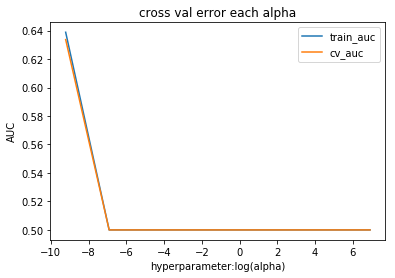

In [77]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l1",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [78]:
clf_avgw2vec_sgd_l1_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_avgw2vec_sgd_l1_alpha)

0.0001


In [79]:
model_avgw2vec_sgd_l1=SGDClassifier(loss="hinge",alpha=clf_avgw2vec_sgd_l1_alpha,penalty="l1",class_weight="balanced")
model_avgw2vec_sgd_l1.fit(X_tr,y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

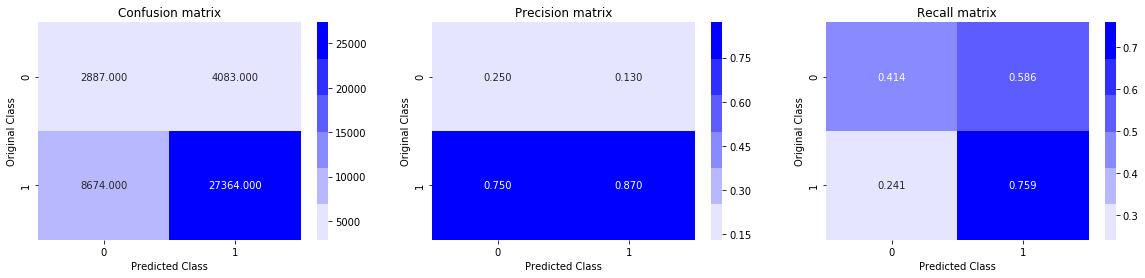

70.33807663690477


In [80]:
#comfusion matrix on train data
y_pred_tr = model_avgw2vec_sgd_l1.predict(X_tr)
acc_tr_avgw2vec_sgd_l1=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_avgw2vec_sgd_l1)

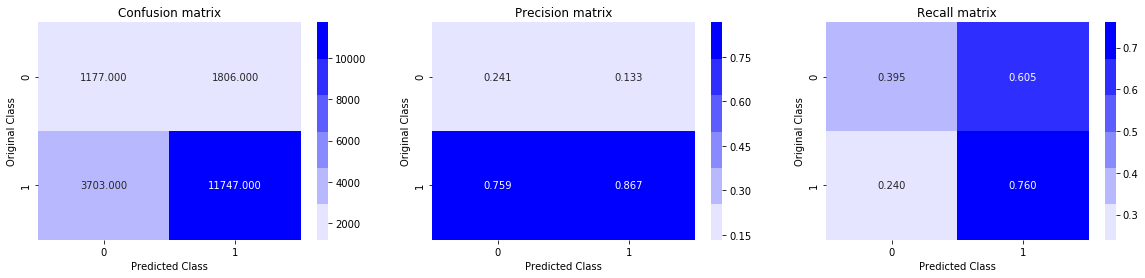

70.11338360549016


In [81]:
#comfusion matrix on train data
y_pred_cv = model_avgw2vec_sgd_l1.predict(X_cv)
acc_cv_avgw2vec_sgd_l1=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_avgw2vec_sgd_l1)

# 4.4 tfidf w2vec

In [82]:
X=final_data["CleanedText"].values
y=final_data["Score"]

In [83]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=2)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_1,y_1,test_size=0.3,random_state=2)

In [84]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [85]:
i=0
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

In [86]:
w2v_model=Word2Vec(list_of_sentance_tr,min_count=5,size=50, workers=4)

In [87]:
w2v_words = list(w2v_model.wv.vocab)

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sentance_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_tr: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #       tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_tr.append(sent_vec)
    row += 1

In [89]:
X_tr=tfidf_sentance_vectors_tr

In [90]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [91]:
tfidf_sentance_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_cv.append(sent_vec)
    row += 1

In [92]:
X_cv=tfidf_sentance_vectors_cv

In [93]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [94]:
tfidf_sentance_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sentance_vectors_test.append(sent_vec)
    row += 1

In [95]:
X_test=tfidf_sentance_vectors_test

In [96]:
X_tr_l1=X_tr
X_cv_l1=X_cv
X_test_l1=X_test
y_tr_l1=y_tr

# l2 regularizer

For values of alpha =  0.0001 The train roc_auc_score is: 0.8685403989298138 And CV roc_auc_score is: 0.8691449332155253
For values of alpha =  0.001 The train roc_auc_score is: 0.8756025501399856 And CV roc_auc_score is: 0.8760153357214245
For values of alpha =  0.01 The train roc_auc_score is: 0.8746999100376898 And CV roc_auc_score is: 0.8757531147101077
For values of alpha =  0.1 The train roc_auc_score is: 0.8740716656486881 And CV roc_auc_score is: 0.8753244230542827
For values of alpha =  1 The train roc_auc_score is: 0.8735114549981158 And CV roc_auc_score is: 0.874685171452649
For values of alpha =  10 The train roc_auc_score is: 0.7688635689388702 And CV roc_auc_score is: 0.7704475925099762
For values of alpha =  100 The train roc_auc_score is: 0.6250482501020367 And CV roc_auc_score is: 0.6205522321279647
For values of alpha =  1000 The train roc_auc_score is: 0.6250490899264565 And CV roc_auc_score is: 0.620553443610238


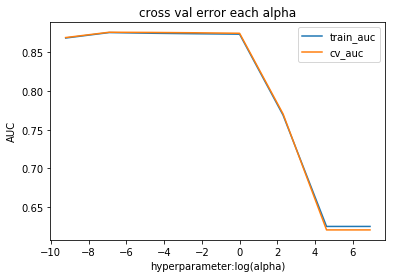

In [97]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [99]:
clf_tfidfw2vec_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_tfidfw2vec_sgd_l2_alpha)

0.001


In [101]:
model_tfidfw2vec_sgd_l2=SGDClassifier(loss="hinge",alpha=clf_tfidfw2vec_sgd_l2_alpha,penalty="l2")
model_tfidfw2vec_sgd_l2.fit(X_tr,y_tr)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

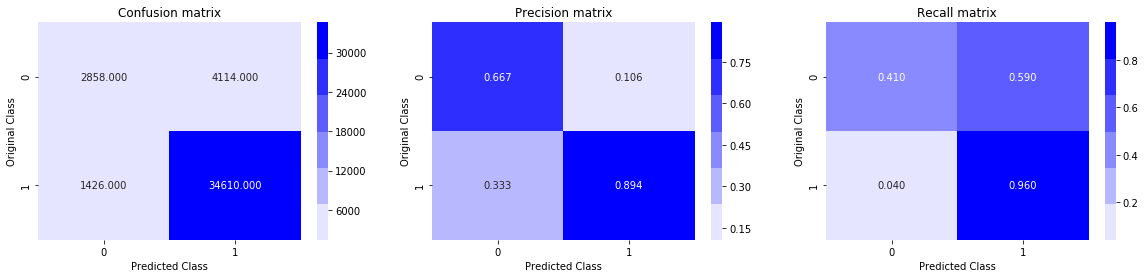

87.11867559523809


In [102]:
#comfusion matrix on train data
y_pred_tr = model_tfidfw2vec_sgd_l2.predict(X_tr)
acc_tr_tfidfw2vec_sgd_l2=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_tfidfw2vec_sgd_l2)

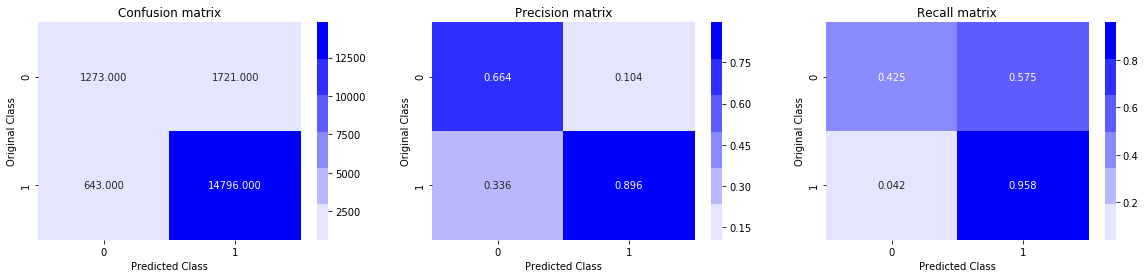

87.17517495795583


In [103]:
#comfusion matrix on train data
y_pred_cv = model_tfidfw2vec_sgd_l2.predict(X_cv)
acc_cv_tfidfw2vec_sgd_l2=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_tfidfw2vec_sgd_l2)

# l1 regularizer

For values of alpha =  0.0001 The train roc_auc_score is: 0.8717074524411013 And CV roc_auc_score is: 0.8741646883810155
For values of alpha =  0.001 The train roc_auc_score is: 0.8727630918358114 And CV roc_auc_score is: 0.8745576629433922
For values of alpha =  0.01 The train roc_auc_score is: 0.8194054881339736 And CV roc_auc_score is: 0.8203101693163297
For values of alpha =  0.1 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  1 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  10 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  100 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5
For values of alpha =  1000 The train roc_auc_score is: 0.5 And CV roc_auc_score is: 0.5


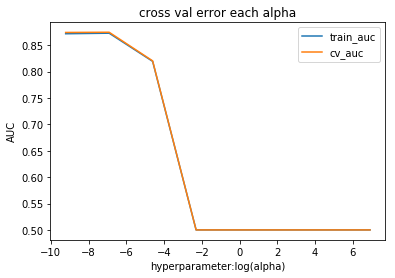

In [104]:
from sklearn.calibration import CalibratedClassifierCV
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l1",alpha=i)
    clf.fit(X_tr,y_tr)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr,y_tr)
    y_tr_predict=clf_prob.predict_proba(X_tr)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [106]:
clf_tfidfw2vec_sgd_l1_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_tfidfw2vec_sgd_l1_alpha)

0.001


In [108]:
model_tfidfw2vec_sgd_l1=SGDClassifier(loss="hinge",alpha=clf_tfidfw2vec_sgd_l1_alpha,penalty="l1")
model_tfidfw2vec_sgd_l1.fit(X_tr,y_tr)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

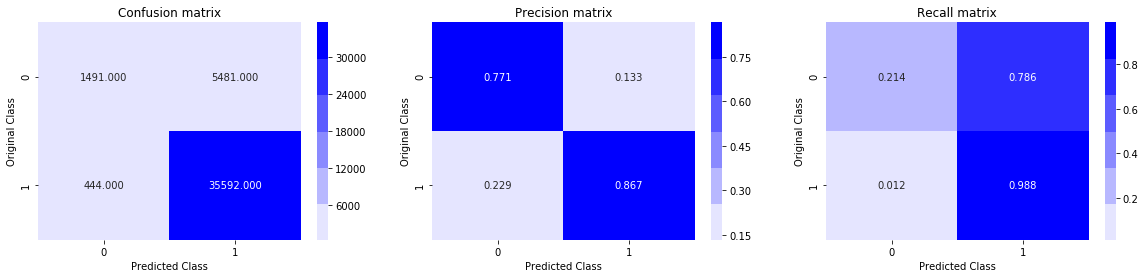

86.22349330357143


In [109]:
#comfusion matrix on train data
y_pred_tr = model_tfidfw2vec_sgd_l1.predict(X_tr)
acc_tr_tfidfw2vec_sgd_l1=accuracy_score(y_tr, y_pred_tr)*100
#confusion matrix on train data
plot_confusion_matrix(y_tr,y_pred_tr)
print(acc_tr_tfidfw2vec_sgd_l1)

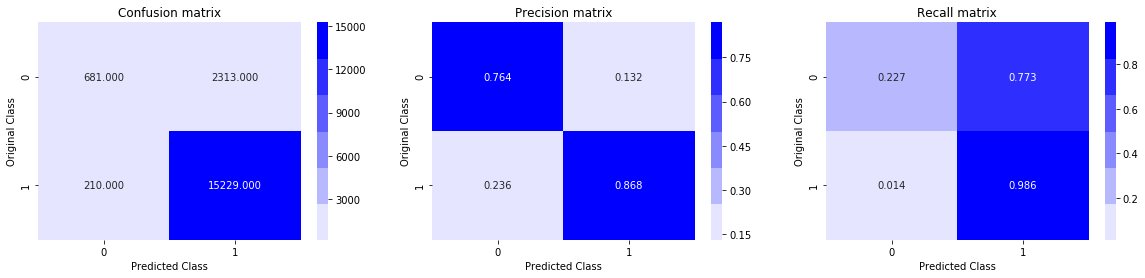

86.3125915477676


In [110]:
#comfusion matrix on train data
y_pred_cv = model_tfidfw2vec_sgd_l1.predict(X_cv)
acc_cv_tfidfw2vec_sgd_l1=accuracy_score(y_cv, y_pred_cv)*100
#confusion matrix on train data
plot_confusion_matrix(y_cv,y_pred_cv)
print(acc_cv_tfidfw2vec_sgd_l1)

In [130]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['SVM(l2) for BoW','SVM(l1|) for BoW',\
         'SVM(l2) for TFIDF','SVM(ll) for TFIDF',\
         'SVM(l2) for Avg_Word2Vec','SVM(l1) for Avg_Word2Vec',\
         'SVM(l2) for tfidf_Word2Vec','SVM(l1) for tfidf_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_alpha = [clf_bow_sgd_l2_alpha,clf_bow_sgd_l1_alpha,\
             clf_tfidfw2vec_sgd_l2_alpha,clf_tfidfw2vec_sgd_l1_alpha,\
             clf_avgw2vec_sgd_l2_alpha,clf_avgw2vec_sgd_l1_alpha,\
             clf_tfidfw2vec_sgd_l2_alpha,clf_tfidfw2vec_sgd_l1_alpha]

# Training accuracies

train_acc = [acc_tr_bow_sgd_l2,acc_tr_bow_sgd_l2,\
             acc_tr_tfidf_sgd_l2,acc_tr_tfidf_sgd_l1,\
             acc_tr_avgw2vec_sgd_l2,acc_tr_avgw2vec_sgd_l1,\
             acc_tr_tfidfw2vec_sgd_l2,acc_tr_tfidfw2vec_sgd_l1]

# Test accuracies
cv_acc =    [acc_cv_bow_sgd_l2,acc_cv_bow_sgd_l2,\
             acc_cv_tfidf_sgd_l2,acc_cv_tfidf_sgd_l1,\
             acc_cv_avgw2vec_sgd_l2,acc_cv_avgw2vec_sgd_l1,\
             acc_cv_tfidfw2vec_sgd_l2,acc_cv_tfidfw2vec_sgd_l1] 

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best alpha",optimal_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("CV Accuracy",cv_acc)


# Printing note regarding information of "MODEL" column in the table
print("NOTE:- In the Table below in 'MODEL' column :")
print("\t SVM(l2|GridSearchCV) : Support Vector Machine with L2 regularisation ")
print("\t SVM(l1|GridSearchCV) : Support Vector Machine with L1 regularisation ")
# Printing the Table
print(ptable)

NOTE:- In the Table below in 'MODEL' column :
	 SVM(l2|GridSearchCV) : Support Vector Machine with L2 regularisation 
	 SVM(l1|GridSearchCV) : Support Vector Machine with L1 regularisation 
+-------+----------------------------+------------+-------------------+-------------------+
| S.NO. |           MODEL            | Best alpha | Training Accuracy |    CV Accuracy    |
+-------+----------------------------+------------+-------------------+-------------------+
|   1   |      SVM(l2) for BoW       |    0.1     | 95.94261532738095 | 86.01421363858299 |
|   2   |      SVM(l1|) for BoW      |   0.0001   | 95.94261532738095 | 86.01421363858299 |
|   3   |     SVM(l2) for TFIDF      |   0.001    | 95.78683035714286 | 91.59116801388814 |
|   4   |     SVM(ll) for TFIDF      |   0.001    | 96.75874255952381 | 87.93468236315304 |
|   5   |  SVM(l2) for Avg_Word2Vec  |   0.0001   | 77.48558407738095 |  77.1008517333044 |
|   6   |  SVM(l1) for Avg_Word2Vec  |   0.0001   | 70.33807663690477 | 70